# Convolutional Neural Network with Only Image Data

In [1]:
import tensorflow as tf
# Check if TensorFlow sees a GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {gpus}")
else:
    print("No GPU detected. Training will use CPU.")

if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# These two packages may need to re-install when switching to a new runtime environment
!pip install -q tensorflow
!pip install -q keras-tuner


In [2]:
import os
import random
import shutil
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt


RANDOM_CODE = 1234

IMAGE_PATH = "Data (1)/Pictures"
RENAME_PATH = "Data (1)/rename.json"
TABLE_DATA_PATH = "Data (1)/regional_combined_centroids.csv"

random.seed(RANDOM_CODE)
np.random.seed(RANDOM_CODE)
tf.random.set_seed(RANDOM_CODE)


### Mount Google Drive (If on Google Colab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

target_folder = "207 Machine Learning: Final Project"
found_path = None

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if target_folder in dirs:
        found_path = os.path.join(root, target_folder)
        break

if found_path:
    os.chdir(found_path)
    print("Changed working directory to:", os.getcwd())
else:
    print(f"Folder '{target_folder}' not found.")


In [3]:
def view_missing_values(df):
    row_count, col_count = df.shape
    summary = pd.DataFrame({
        'Missing Value Count': df.isnull().sum(),
        'Proportion of Missing Values': df.isnull().sum() / row_count,
        'Data Type': df.dtypes
    })
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(summary)
        print("Shape of the data frame", df.shape)

def drop_columns_missing_proportion(df, proportion, drop=None):
    row_count, col_count = df.shape
    summary = pd.DataFrame(df.isnull().sum(), columns=['Missing Value Count'])
    summary['Proportion of Missing Values'] = summary['Missing Value Count'] / row_count
    cols_to_drop = summary[summary['Proportion of Missing Values'] >= proportion].index.tolist()
    df.drop(columns=cols_to_drop, inplace=True)
    print(f'Dropping columns with more than {proportion * 100:.2f}% missing values: ', cols_to_drop)


## <span style="color:chocolate">1. Data Preprocessing</span>




### 1.1 Census Data Pre-processing

In [4]:
# Read in the data
centroids_data = pd.read_csv(TABLE_DATA_PATH, dtype={'CensusTract': str})
centroids_data.drop(columns=['state'], inplace=True) # state and State are duplicated columns

# Rename the columns
with open(RENAME_PATH, 'r') as f:
    rename = json.load(f)

rename_dict = {}
for col in centroids_data.columns:
    if col in rename.keys():
         rename_dict[col] = rename[col]['simplifiedName']

centroids_data.rename(columns=rename_dict, inplace=True)

# Make sure the TractID column is properly converted to string type
centroids_data['TractID'] = centroids_data['TractID'].astype(str).str.zfill(11)

# Pad 10-digit GEOIDs to 11-digit strings
centroids_data['GEOID'] = centroids_data['GEOID'].astype(str).str.zfill(11)

# Define a function to classify tracts as food deserts
def is_food_desert(row):
    return 1 if (row["LILA_Urban1_Rural10"] == 1) else 0

# Create a new column in the DataFrame to indicate food deserts
centroids_data["IsFoodDesert"] = centroids_data.apply(is_food_desert, axis=1)

# Drop unnecessary columns
centroids_data.drop(columns=["CountyName", "LILA_Urban1_Rural10", "GEOID"], inplace=True)

# Drop columns with more than 50% missing values
drop_columns_missing_proportion(centroids_data, 0.2)

# Impute missing values using median number
df = pd.DataFrame(centroids_data.isnull().sum(), columns=['Missing Value Count'])
df['Proportion of Missing Values'] = df['Missing Value Count'] / len(centroids_data)
cols_to_fill = df[df['Proportion of Missing Values'] > 0.006].index.tolist()

# Impute missing values of Median Income with median value
for col in cols_to_fill:
    centroids_data[col].fillna(centroids_data[col].median(), inplace=True)

# Change these columns to float type
to_float_cols = [
    "Pop2010",
    "OccupiedHousingUnits",
    "GroupQuartersPopulation",
    "LowIncomePopulation",
    "ChildPopulation",
    "SeniorPopulation",
    "WhitePopulation",
    "BlackPopulation",
    "AsianPopulation",
    "NHPIPopulation",
    "AIANPopulation",
    "MultiracialPopulation",
    "HispanicPopulation",
    "NoVehicleHouseholds",
    "SNAPRecipients"]
centroids_data[to_float_cols] = centroids_data[to_float_cols].astype(float)

# Print data types
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(centroids_data.dtypes)

Dropping columns with more than 20.00% missing values:  ['LAPop_Urban1_Rural10', 'LAPop_UrbanHalf_Rural10', 'LAPop_Urban1_Rural20', 'LALowIncome_Urban1_Rural10', 'LALowIncome_UrbanHalf_Rural10', 'LALowIncome_Urban1_Rural20', 'LAPop_10Miles', 'LAPopShare_10Miles', 'LALowIncome_10Miles', 'LALowIncomeShare_10Miles', 'LAKids_10Miles', 'LAKidsShare_10Miles', 'LASeniors_10Miles', 'LASeniorsShare_10Miles', 'LAWhite_10Miles', 'LAWhiteShare_10Miles', 'LABlack_10Miles', 'LABlackShare_10Miles', 'LAAsian_10Miles', 'LAAsianShare_10Miles', 'LANHPI_10Miles', 'LANHPIShare_10Miles', 'LAAIAN_10Miles', 'LAAIANShare_10Miles', 'LAMultiracial_10Miles', 'LAMultiracialShare_10Miles', 'LAHispanic_10Miles', 'LAHispanicShare_10Miles', 'LANoVehicle_10Miles', 'LANoVehicleShare_10Miles', 'LASNAP_10Miles', 'LASNAPShare_10Miles', 'LAPop_20Miles', 'LAPopShare_20Miles', 'LALowIncome_20Miles', 'LALowIncomeShare_20Miles', 'LAKids_20Miles', 'LAKidsShare_20Miles', 'LASeniors_20Miles', 'LASeniorsShare_20Miles', 'LAWhite_20M

### 1.2 Reading In Training Images

- Steps:
    1. Split data but put it back as a data frame
    2. Drop Columns
    3. Do transformation but puck it back as a data frame
    4. Load Images for training, validation, and testing set
    5. Convert everything back to arrays


In [5]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def load_images_to_array(df, folder_path, image_size=(256, 256)):
    '''
    Match each row to its image using IsFoodDesert and TractID, then load images into a NumPy array.
    Assumes image filenames are in the format: <IsFoodDesert>_<TractID>.jpg/png/jpeg
    '''
    image_arrays = []
    unmatched = []

    for i, row in df.iterrows():
        filename = f"{row['IsFoodDesert']}_{row['TractID']}"

        # Try all common image extensions
        found = False
        for ext in ['.jpg', '.jpeg', '.png']:
            img_path = os.path.join(folder_path, row['StateName'], filename + ext)
            if os.path.exists(img_path):
                try:
                    img = load_img(img_path, target_size=image_size)
                    img_array = img_to_array(img).astype('float32') # / 255.0
                    image_arrays.append(img_array)
                    found = True
                    break
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    image_arrays.append(None)
                    found = True
                    break  # Still break if file exists but failed to load

        if not found:
            unmatched.append(filename)
            image_arrays.append(None)

    if unmatched:
        print(f"⚠️ {len(unmatched)} images not found: {unmatched[:5]}{'...' if len(unmatched) > 5 else ''}")

    # Filter out None values (if needed)
    valid_images = [img for img in image_arrays if img is not None]

    return np.array(valid_images)

### Data Transformation

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


def split_transform(splits=(0.6, 0.2, 0.2)):
    """
    1. Keep TractID and IsFoodDesert for image alignment and labels.
    2. Drop non-feature columns only during transformation.
    3. Return both raw and transformed sets for parallel use.
    """
    df = centroids_data.copy()

    # Preserve for image loading and label
    y = df['IsFoodDesert']

    # These columns will NOT be used for transformation
    cols_to_exclude = ['latitude', 'longitude', 'IsFoodDesert', 'TractID', 'StateName']

    # Subset features for transformation
    features = df.drop(columns=cols_to_exclude)

    # Identify feature types
    numeric_features = features.select_dtypes(include=['float64']).columns.tolist()
    binary_features = features.select_dtypes(include=['int64']).columns.tolist()
    object_features = features.select_dtypes(include=['object']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('bin', 'passthrough', binary_features),
            ('obj', 'passthrough', object_features)
        ]
    )

    # Split raw dataframe for image and ID use
    X_train_df, X_temp_df, y_train, y_temp = train_test_split(df, y, test_size=splits[1] + splits[2], random_state=RANDOM_CODE)
    X_val_df, X_test_df, y_val, y_test = train_test_split(X_temp_df, y_temp, test_size=splits[2] / (splits[1] + splits[2]), random_state=RANDOM_CODE)

    # Subset features for transformation
    X_train_features = X_train_df.drop(columns=cols_to_exclude)
    X_val_features = X_val_df.drop(columns=cols_to_exclude)
    X_test_features = X_test_df.drop(columns=cols_to_exclude)

    # Fit and transform
    preprocessor.fit(X_train_features)
    X_train_scaled = preprocessor.transform(X_train_features).astype(np.float32)
    X_val_scaled = preprocessor.transform(X_val_features).astype(np.float32)
    X_test_scaled = preprocessor.transform(X_test_features).astype(np.float32)

    # Labels
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)
    y_test = y_test.astype(np.float32)

    # Return both transformed features and raw split data for image access
    return (
        X_train_scaled, X_val_scaled, X_test_scaled,
        X_train_df, X_val_df, X_test_df,  # for TractID and image lookup
        y_train, y_val, y_test
    )


In [7]:
X_tab_train, X_tab_val, X_tab_test, \
X_train_df, X_val_df, X_test_df, \
y_train, y_val, y_test = split_transform()

X_img_train = load_images_to_array(X_train_df, IMAGE_PATH)
X_img_val = load_images_to_array(X_val_df, IMAGE_PATH)
X_img_test = load_images_to_array(X_test_df, IMAGE_PATH)


print("X_tab_train shape:", X_tab_train.shape)
print("X_tab_val shape:", X_tab_val.shape)
print("X_tab_test shape:", X_tab_test.shape)
print("X_img_train shape:", X_img_train.shape)
print("X_img_val shape:", X_img_val.shape)
print("X_img_test shape:", X_img_test.shape)


X_tab_train shape: (4272, 85)
X_tab_val shape: (1424, 85)
X_tab_test shape: (1425, 85)
X_img_train shape: (4272, 256, 256, 3)
X_img_val shape: (1424, 256, 256, 3)
X_img_test shape: (1425, 256, 256, 3)


## <span style="color:chocolate">2. CNN Model Building</span>

### CMM Model Creation

In [8]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import models, layers, Input, Model

# Build CNN model
def create_cnn_model(image_input_shape, tabular_input_shape):

    tf.keras.backend.clear_session()
    tf.random.set_seed(RANDOM_CODE)

    # Image input branch (CNN)
    image_input = Input(shape=image_input_shape)

    x = layers.Rescaling(1./255)(image_input)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(64, activation='relu')(x)
    image_branch = layers.Dropout(0.5)(x)

    # Tabular input branch (MLP)
    tabular_input = Input(shape=tabular_input_shape)
    y = layers.Dense(64, activation='relu')(tabular_input)
    # y = layers.BatchNormalization()(y)
    y = layers.Dropout(0.3)(y)
    y = layers.Dense(32, activation='relu')(y)
    tabular_branch = layers.Dropout(0.3)(y)

    # Combine both
    combined = layers.concatenate([image_branch, tabular_branch])
    z = layers.Dense(64, activation='relu')(combined)
    z = layers.Dropout(0.4)(z)
    output = layers.Dense(1, activation='sigmoid')(z)

    model = Model(inputs=[image_input, tabular_input], outputs=output)
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model


Using TensorFlow backend


### Model Implementation

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# train the model
model = create_cnn_model(image_input_shape= (256, 256, 3), tabular_input_shape=(X_tab_train.shape[1],))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=3,
    mode='min',
    restore_best_weights=True
)

weights = compute_class_weight(class_weight='balanced',
                                classes=np.unique(y_train),
                                y=y_train)
class_weight = dict(enumerate(weights))


history = model.fit(
    x=[X_img_train, X_tab_train],
    y=y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    batch_size=32,
    epochs=20,
    class_weight=class_weight,
    callbacks=[early_stopping]
)

2025-08-04 13:49:55.061980: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-08-04 13:49:55.062011: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-04 13:49:55.062020: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-08-04 13:49:55.062248: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-04 13:49:55.062273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2025-08-04 13:50:02.789534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


134/134 [==============================] - 33s 233ms/step - loss: 0.4620 - accuracy: 0.7912 - val_loss: 0.2344 - val_accuracy: 0.9221
Epoch 2/20
134/134 [==============================] - 28s 206ms/step - loss: 0.2193 - accuracy: 0.9082 - val_loss: 0.0554 - val_accuracy: 0.9909
Epoch 3/20
134/134 [==============================] - 27s 205ms/step - loss: 0.1065 - accuracy: 0.9583 - val_loss: 0.0362 - val_accuracy: 0.9930
Epoch 4/20
134/134 [==============================] - 28s 206ms/step - loss: 0.0358 - accuracy: 0.9860 - val_loss: 0.0104 - val_accuracy: 0.9972
Epoch 5/20
134/134 [==============================] - 28s 210ms/step - loss: 0.0357 - accuracy: 0.9878 - val_loss: 0.0034 - val_accuracy: 0.9993
Epoch 6/20
134/134 [==============================] - 28s 209ms/step - loss: 0.0301 - accuracy: 0.9923 - val_loss: 0.0213 - val_accuracy: 0.9951
Epoch 7/20
134/134 [==============================] - 28s 212ms/step - loss: 0.0249 - accuracy: 0.9937 - val_loss: 0.0083 - val_accuracy: 0.9

### Model Evaluation - Training and Validation

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


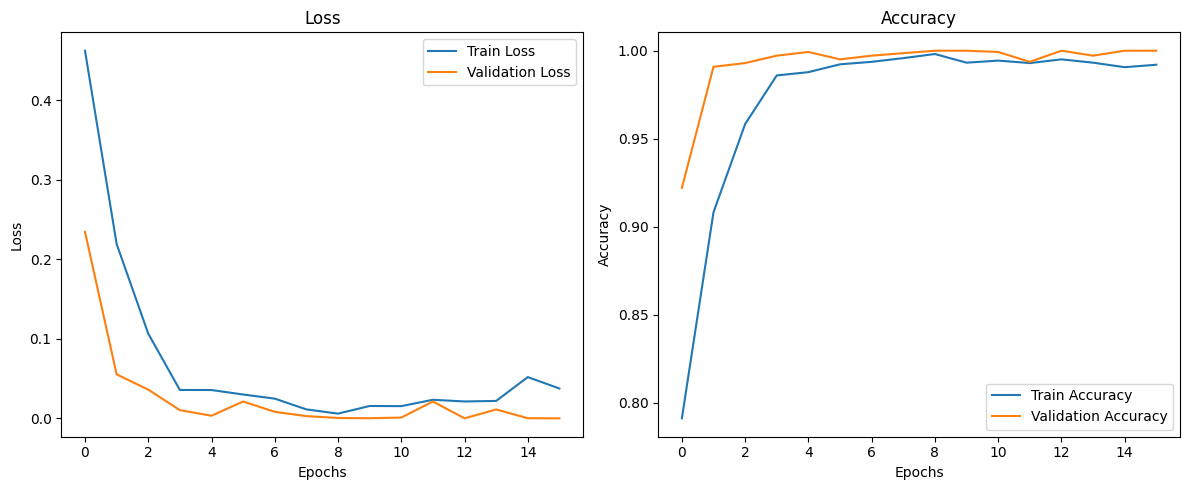

In [10]:
print(history.history.keys())

# draw the training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Evaluate the model
test_loss, test_accuracy = model.evaluate([X_img_test, X_tab_test], y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred_probs = model.predict([X_img_test, X_tab_test]).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
print(classification_report(y_test, y_pred))



45/45 [==============================] - 3s 67ms/step - loss: 3.8939e-04 - accuracy: 1.0000
Test Loss: 0.0004
Test Accuracy: 1.0000
45/45 [==============================] - 3s 63ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1120
         1.0       1.00      1.00      1.00       305

    accuracy                           1.00      1425
   macro avg       1.00      1.00      1.00      1425
weighted avg       1.00      1.00      1.00      1425



Confusion Matrix:
[[1120    0]
 [   0  305]]


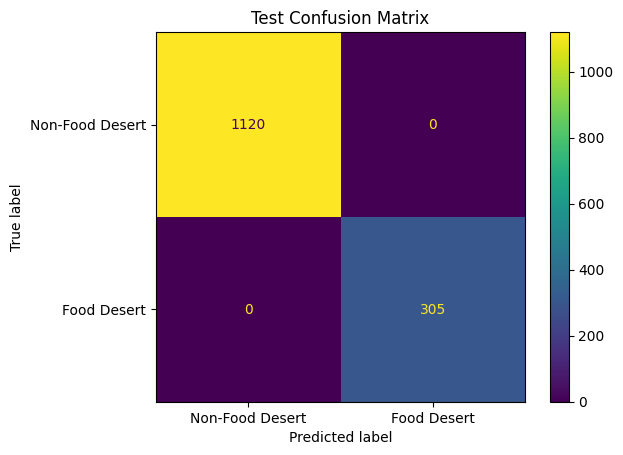

Training Data Results:
True Positives training (TP): 305
False Negatives training(FN): 0
False Positives traniing(FP): 0
True Negatives traniing(TN): 1120
The test precision is 1.00.
The test recall is 1.00.
The F1 score is 1.0.


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
table_validation= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Food Desert', 'Food Desert']) 
table_validation.plot()
table_validation.ax_.set_title('Test Confusion Matrix')
plt.show()

TN, FP, FN, TP = cm.ravel()
print("Training Data Results:")
print(f"True Positives training (TP): {TP}")
print(f"False Negatives training(FN): {FN}")
print(f"False Positives traniing(FP): {FP}")
print(f"True Negatives traniing(TN): {TN}")

# Precision is how often the model is correct when predicting food deserts
precision_test = TP/(TP+FP)

# Recall is whether the model can find all food deserts
recall_test = TP/(TP+FN)

print(f"The test precision is {precision_test:.2f}.")
print(f"The test recall is {recall_test:.2f}.")
print(f"The F1 score is {f1_score(y_test, y_pred)}.")


In [13]:
# Convert X_val back to [0, 255] for visualization
X_img_test_display = (X_img_test).astype(np.uint8)

# index of wrong misclassification in test set
misclassified_idx = np.where(y_pred != y_test)[0]
misclassified_imgs = X_img_test_display[misclassified_idx]
misclassified_labels = y_val[misclassified_idx]
predicted_labels = y_pred[misclassified_idx]

plt.figure(figsize=(15, len(misclassified_imgs) * 3 // 5))

for i in range(len(misclassified_imgs)):
    plt.subplot((len(misclassified_imgs) + 4) // 5, 5, i + 1)
    plt.imshow(misclassified_imgs[i])
    plt.title(f"True: {misclassified_labels[i]}, Pred: {predicted_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


<Figure size 1500x0 with 0 Axes>

In [ ]:
# # One-Off thing to rename Arkansas and Alabama images
# import os

# states = ['Arkansas', 'Alabama']
# data_path = 'Data/Pictures/'

# for state in states:
#     state_path = os.path.join(data_path, state)
#     if os.path.exists(state_path):
#         for filename in os.listdir(state_path):
#             if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
#                 file_base, file_ext = os.path.splitext(filename)
#                 try:
#                     parts = file_base.split("_")
#                     if len(parts) == 2:
#                         label, tract_id = parts
#                         padded_tract_id = tract_id.zfill(11)
#                         new_filename = f"{label}_{padded_tract_id}{file_ext}"
#                         old_filepath = os.path.join(state_path, filename)
#                         new_filepath = os.path.join(state_path, new_filename)
#                         if old_filepath != new_filepath:
#                             os.rename(old_filepath, new_filepath)
#                             print(f"Renamed '{filename}' to '{new_filename}'")
#                     else:
#                         print(f"Skipping file with unexpected format: {filename}")
#                 except Exception as e:
#                     print(f"Error processing file {filename}: {e}")
#     else:
#         print(f"State folder not found: {state_path}")